In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ZeltaDataset/BTC23/BTC_20_23/df_btc_20_23_15m.csv')
#df = pd.read_csv('/content/drive/MyDrive/OwnDataset/btc_17_19_15m.csv')

In [ ]:
df

,Unnamed: 0.1,datetime,open,high,low,close,volume,Unnamed: 0
0,0,2020-01-01 00:00:00,7168.22,7174.04,7157.75,7170.73,168.907540,NaN
1,1,2020-01-01 00:15:00,7169.71,7171.91,7156.24,7168.86,169.017556,NaN
2,2,2020-01-01 00:30:00,7169.32,7170.41,7158.62,7159.63,280.735630,NaN
3,3,2020-01-01 00:45:00,7158.72,7182.14,7156.85,7175.55,163.905487,NaN
4,4,2020-01-01 01:00:00,7175.55,7178.93,7168.00,7174.61,160.193588,NaN
...,...,...,...,...,...,...,...,...
140004,140004,2024-01-01 04:30:00,42257.89,42345.65,42196.61,42230.13,637.999230,35031.0
140005,140005,2024-01-01 04:45:00,42230.14,42235.09,42066.00,42181.80,614.770270,35032.0
140006,140006,2024-01-01 05:00:00,42181.81,42242.95,42154.34,42241.09,215.210450,35033.0
140007,140007,2024-01-01 05:15:00,42241.09,42283.59,42221.22,42283.58,242.157260,35034.0


In [ ]:
df.shape[0]

140009

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [ ]:
df['SMA_15m'] = df['close'].rolling(window=7).mean()
df['VOLAT_15m'] = df['close'].rolling(window=7).std()

In [ ]:
df = df[['datetime', 'open', 'high', 'low', 'close', 'volume', 'SMA_15m', 'VOLAT_15m']]

In [ ]:
df

,datetime,open,high,low,close,volume,SMA_15m,VOLAT_15m
0,2020-01-01 00:00:00,7168.22,7174.04,7157.75,7170.73,168.907540,NaN,NaN
1,2020-01-01 00:15:00,7169.71,7171.91,7156.24,7168.86,169.017556,NaN,NaN
2,2020-01-01 00:30:00,7169.32,7170.41,7158.62,7159.63,280.735630,NaN,NaN
3,2020-01-01 00:45:00,7158.72,7182.14,7156.85,7175.55,163.905487,NaN,NaN
4,2020-01-01 01:00:00,7175.55,7178.93,7168.00,7174.61,160.193588,NaN,NaN
...,...,...,...,...,...,...,...,...
140004,2024-01-01 04:30:00,42257.89,42345.65,42196.61,42230.13,637.999230,42455.632857,149.513615
140005,2024-01-01 04:45:00,42230.14,42235.09,42066.00,42181.80,614.770270,42395.701429,164.693242
140006,2024-01-01 05:00:00,42181.81,42242.95,42154.34,42241.09,215.210450,42355.754286,163.221636
140007,2024-01-01 05:15:00,42241.09,42283.59,42221.22,42283.58,242.157260,42322.558571,148.144404


In [ ]:
df = df.dropna()

In [ ]:
#df.shape[0]
df = df[df['VOLAT_15m'] != 0]

In [ ]:
df.isnull().sum()

datetime     0
open         0
high         0
low          0
close        0
volume       0
SMA_15m      0
VOLAT_15m    0
dtype: int64

In [ ]:
max_deviation = 2
exit_limit = 4
holding_candle = 90
signals = None
pnl = 0
holding_count = 0
df['signals'] = df['open']*0
df['pnll'] = df['open']*0
df['exit_point'] = df['open']*0
df['profit_losss'] = df['open']*0
bank_balance = 1000
i=0
no_of_trades = 0
prev_position = 0

In [ ]:
df.shape[0]

140003

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
while (i < df.shape[0]):
  #for j in range(0, df.shape[1]):
    deviation = (df.loc[i, 'close'] - df.loc[i, 'SMA_15m']) / df.loc[i, 'VOLAT_15m']

    #if (bank_balance <= 0): break
    if (deviation > max_deviation):

      signals = 'long'
      df.loc[i, 'signals'] = 1
      entry_price = df.loc[i, 'close']
      #bank_balance -= entry_price
      exit_price = None
    elif (deviation < -max_deviation):

      signals = 'short'
      df.loc[i, 'signals'] = -1
      entry_price = df.loc[i, 'close']
      #bank_balance -= entry_price
      exit_price = None

    #print(deviation)
    prev_position = i
    if signals:
      if (signals == 'short'):
        while(holding_count < holding_candle and (deviation > -exit_limit) and i<df.shape[0]-1):
          deviation = (df.loc[i, 'close'] - df.loc[i, 'SMA_15m']) / df.loc[i, 'VOLAT_15m']
          exit_price = df.loc[i, 'close']
          profit_loss = (entry_price - exit_price) * (bank_balance / entry_price)
          if(profit_loss < -70):
            holding_count = 89
          i += 1
          holding_count += 1

        i-=1
        exit_price = df.loc[i, 'close']
        profit_loss = (entry_price - exit_price) * (bank_balance / entry_price)
        #if(profit_loss > 1.5):
        no_of_trades += 1
        #bank_balance += exit_price
        df.loc[i, 'exit_point'] = 'Exit'
        df.loc[i, 'signals'] = 1
        #profit_loss = (entry_price - exit_price) * (bank_balance / entry_price)
        df.loc[i, 'profit_losss'] = profit_loss
        pnl += (entry_price - exit_price) * (bank_balance / entry_price)
        df.loc[i, 'pnll'] = pnl
        signals = None
        #else:
          #df.loc[prev_position, 'signals'] = 0
      elif (signals == 'long'):
        while(holding_count < holding_candle and (deviation < exit_limit) and i<df.shape[0]-1):
          deviation = (df.loc[i, 'close'] - df.loc[i, 'SMA_15m']) / df.loc[i, 'VOLAT_15m']
          exit_price = df.loc[i, 'close']
          profit_loss = (entry_price - exit_price) * (bank_balance / entry_price)
          if(profit_loss < -70):
            holding_count = 89
          i += 1
          holding_count += 1

        i-=1
        exit_price = df.loc[i, 'close']
        profit_loss = (exit_price - entry_price) * (bank_balance / entry_price)
        #if(profit_loss > 1.5):
        no_of_trades += 1
        #bank_balance += exit_price
        df.loc[i, 'exit_point'] = 'Exit'
        df.loc[i, 'signals'] = -1
        df.loc[i, 'profit_losss'] = profit_loss
        pnl += (exit_price - entry_price) * (bank_balance / entry_price)
        df.loc[i, 'pnll'] = pnl
        signals = None
        #else:
          #df.loc[prev_position, 'signals'] = 0

    #print(holding_count)
    holding_count = 0

    i+=1


#print(bank_balance)

In [ ]:
brokerage = no_of_trades * 0.0015 * bank_balance
print(brokerage)

1761.0000000000002


In [ ]:
print(no_of_trades)

1174


In [ ]:
print("Profit and Loss: ${:.2f}".format(pnl))

Profit and Loss: $3062.86


In [ ]:
df

,datetime,open,high,low,close,volume,SMA_15m,VOLAT_15m,signals,pnll,exit_point,profit_losss
0,2020-01-01 01:30:00,7173.75,7180.00,7165.10,7168.05,132.470695,7170.107143,5.418618,0.0,0.000000,0.0,0.000000
1,2020-01-01 01:45:00,7168.01,7179.81,7165.76,7173.95,123.131758,7170.567143,5.613480,0.0,0.000000,0.0,0.000000
2,2020-01-01 02:00:00,7173.56,7187.89,7169.36,7175.64,135.523405,7171.535714,5.849780,0.0,0.000000,0.0,0.000000
3,2020-01-01 02:15:00,7176.44,7178.00,7170.00,7176.41,117.178154,7173.932857,2.802027,0.0,0.000000,0.0,0.000000
4,2020-01-01 02:30:00,7176.51,7184.57,7171.01,7182.44,118.897253,7174.917143,4.283354,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
139998,2024-01-01 04:30:00,42257.89,42345.65,42196.61,42230.13,637.999230,42455.632857,149.513615,0.0,0.000000,0.0,0.000000
139999,2024-01-01 04:45:00,42230.14,42235.09,42066.00,42181.80,614.770270,42395.701429,164.693242,0.0,0.000000,0.0,0.000000
140000,2024-01-01 05:00:00,42181.81,42242.95,42154.34,42241.09,215.210450,42355.754286,163.221636,0.0,0.000000,0.0,0.000000
140001,2024-01-01 05:15:00,42241.09,42283.59,42221.22,42283.58,242.157260,42322.558571,148.144404,1.0,3062.863067,Exit,3.415159


In [ ]:
df['pnll'].max()

3436.3299616299773

In [ ]:
df['pnll'].min()

-123.24131871551597

In [ ]:
df['close'].max()

68718.9

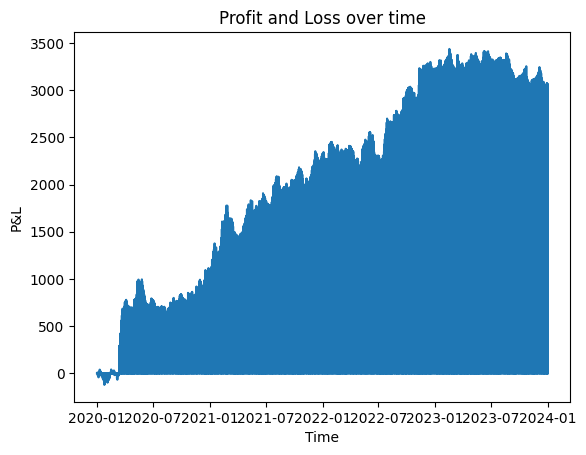

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df['datetime'], df['pnll'])
plt.xlabel('Time')
plt.ylabel('P&L')
_ = plt.title('Profit and Loss over time')

In [ ]:
time_logs = df[['datetime', 'open', 'high', 'low', 'close', 'volume', 'signals']]

In [ ]:
time_logs

,datetime,open,high,low,close,volume,signals
0,2020-01-01 01:30:00,7173.75,7180.00,7165.10,7168.05,132.470695,0.0
1,2020-01-01 01:45:00,7168.01,7179.81,7165.76,7173.95,123.131758,0.0
2,2020-01-01 02:00:00,7173.56,7187.89,7169.36,7175.64,135.523405,0.0
3,2020-01-01 02:15:00,7176.44,7178.00,7170.00,7176.41,117.178154,0.0
4,2020-01-01 02:30:00,7176.51,7184.57,7171.01,7182.44,118.897253,0.0
...,...,...,...,...,...,...,...
139998,2024-01-01 04:30:00,42257.89,42345.65,42196.61,42230.13,637.999230,0.0
139999,2024-01-01 04:45:00,42230.14,42235.09,42066.00,42181.80,614.770270,0.0
140000,2024-01-01 05:00:00,42181.81,42242.95,42154.34,42241.09,215.210450,0.0
140001,2024-01-01 05:15:00,42241.09,42283.59,42221.22,42283.58,242.157260,1.0


In [ ]:
time_logs.to_csv('time_log.csv')